In [ ]:
pip install statsforecast

In [50]:
def visualize(train, test, title):
    fig, ax = plt.subplots(1, 1, figsize = (20, 8))

    plot_df = pd.concat([train, test]).set_index('date')
    plot_df.plot(ax=ax, linewidth=2)

    ax.set_title(title, fontsize=22)
    ax.set_ylabel('reviews', fontsize=20)
    ax.set_xlabel('date', fontsize=20)
    ax.legend(prop={'size': 15})
    ax.grid()

    plt.axvline(x=test_date, color='red', linestyle='--', lw=1)

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import numpy as np
import statsmodels.api as sm


In [52]:
#COVID data
covid_cases = pd.read_csv('covid_cases_by_date.csv', sep=';')
covid_cases['collection_date'] = pd.to_datetime(covid_cases['collection_date'], format='%d/%m/%Y %H:%M')

covid_cases = covid_cases[covid_cases['test_result'] == 'positive'] # Filter for positive test results only, ok?

covid_cases_daily = covid_cases.groupby(covid_cases['collection_date'].dt.date)['count'].sum().reset_index()
covid_cases_daily['collection_date'] = pd.to_datetime(covid_cases_daily['collection_date'])

covid_cases_daily.set_index('collection_date', inplace=True)
covid_cases_monthly = covid_cases_daily.resample('M').sum().reset_index()
covid_cases_monthly.rename(columns={'collection_date': 'date', 'count': 'covid_cases'}, inplace=True)


C:\Users\asus\AppData\Local\Temp\ipykernel_21076\151718774.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  covid_cases_monthly = covid_cases_daily.resample('M').sum().reset_index()


In [53]:
covid_cases_monthly.head()

,date,covid_cases
0,2020-03-31,3190
1,2020-04-30,12929
2,2020-05-31,7059
3,2020-06-30,3451
4,2020-07-31,4296


In [54]:
reviews = pd.read_csv("yelp_academic_dataset_review.csv")
businesses = pd.read_csv("yelp_academic_dataset_business.csv")

reviews = reviews.merge(businesses, how='left', on='business_id')
reviews = reviews[(reviews['city'] == 'Philadelphia') & (reviews['categories'].str.contains('Restaurants', na=False))]
reviews.reset_index(drop=True, inplace=True)


In [55]:
reviews.head(1) 

,review_id,user_id,business_id,stars_x,useful,funny,cool,text,date,name,...,state,postal_code,latitude,longitude,stars_y,review_count,is_open,attributes,categories,hours
0,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,Zaika,...,PA,19114,40.079848,-75.02508,4.0,181,1,"{'Caters': 'True', 'Ambience': ""{'romantic': F...","Halal, Pakistani, Restaurants, Indian","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21..."


In [56]:
#prepare date
reviews['date'] = pd.to_datetime(reviews['date'])
ts = reviews.groupby(reviews['date'].dt.date).size().reset_index(name='count')
ts['date'] = pd.to_datetime(ts['date'])
ts.set_index('date', inplace=True)
monthly_reviews = ts.resample('M').sum().reset_index()
print(monthly_reviews)

          date  count
0   2005-02-28      1
1   2005-03-31      0
2   2005-04-30      0
3   2005-05-31      5
4   2005-06-30      9
..         ...    ...
199 2021-09-30   3260
200 2021-10-31   3367
201 2021-11-30   2811
202 2021-12-31   3110
203 2022-01-31   1849

[204 rows x 2 columns]


C:\Users\asus\AppData\Local\Temp\ipykernel_21076\166029622.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_reviews = ts.resample('M').sum().reset_index()


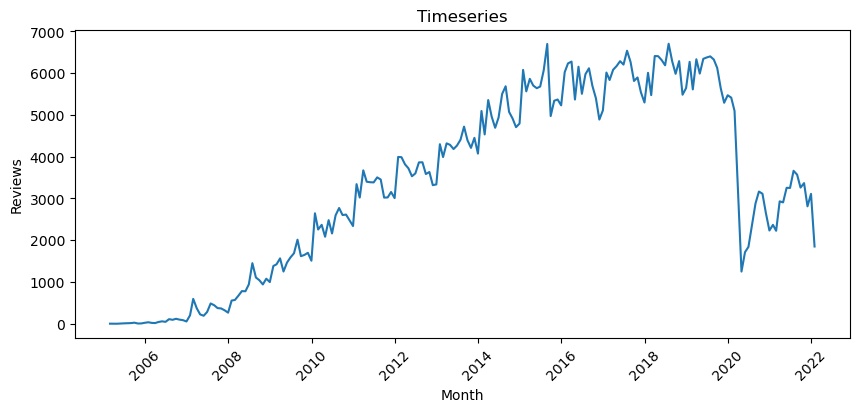

In [57]:
#plot
plt.figure(figsize=(10, 4))
plt.plot(monthly_reviews['date'], monthly_reviews['count'])  
plt.xlabel('Month')
plt.ylabel('Reviews')
plt.title('Timeseries')
plt.xticks(rotation=45)
plt.show()

In [58]:
# train test split
test_date = '2021-01-01'
target = 'count'

ts_train = monthly_reviews[monthly_reviews['date'] <= test_date][['date', target]]
ts_test = monthly_reviews[monthly_reviews['date'] > test_date][['date', target]]

count_train = ts_train[target].values
count_test = ts_test[target].values

horizon = len(ts_test)

C:\Users\asus\AppData\Local\Temp\ipykernel_21076\2873846614.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  monthly_reviews2['covid_cases'].fillna(0, inplace=True)


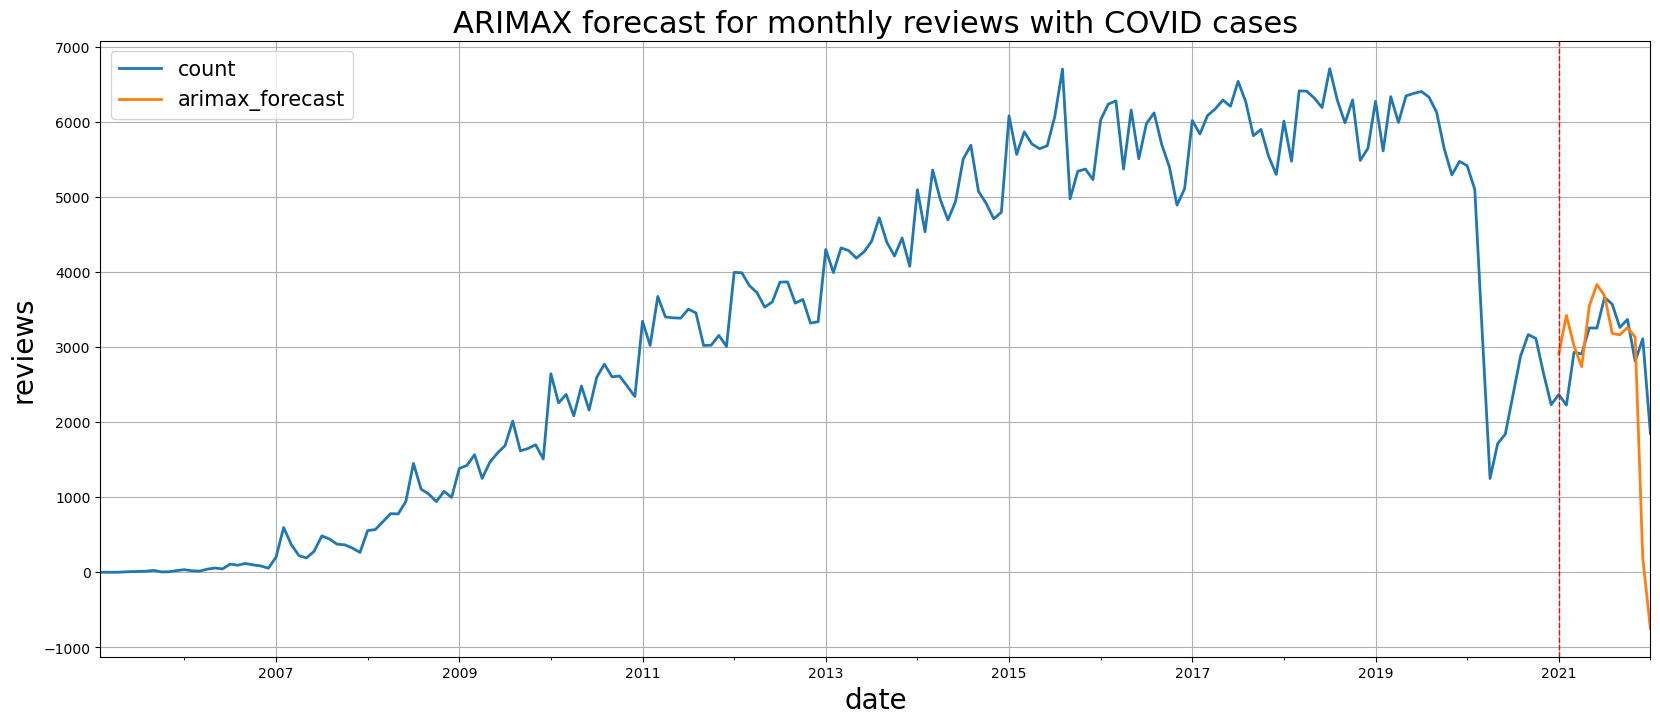

In [59]:
monthly_reviews2 = monthly_reviews.merge(covid_cases_monthly[['date', 'covid_cases']], how='left', on='date')
monthly_reviews2['covid_cases'].fillna(0, inplace=True)
exog_var = ['covid_cases']

exog_train = monthly_reviews2[monthly_reviews2['date'] <= test_date][exog_var]
exog_test = monthly_reviews2[monthly_reviews2['date'] > test_date][exog_var]

import statsmodels.api as sm

arimax_model = sm.tsa.SARIMAX(count_train,  exog=exog_train).fit() #order=(p, d, q),

y_hat_arimax = arimax_model.get_forecast(steps=horizon, exog=exog_test)
ts_test['arimax_forecast'] = y_hat_arimax.predicted_mean

visualize(ts_train[['date', target]], ts_test[['date', target, 'arimax_forecast']], 'ARIMAX forecast for monthly reviews with COVID cases')


C:\Users\asus\AppData\Local\Temp\ipykernel_21076\2196372242.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  monthly_reviews2['covid_cases'].fillna(0, inplace=True)


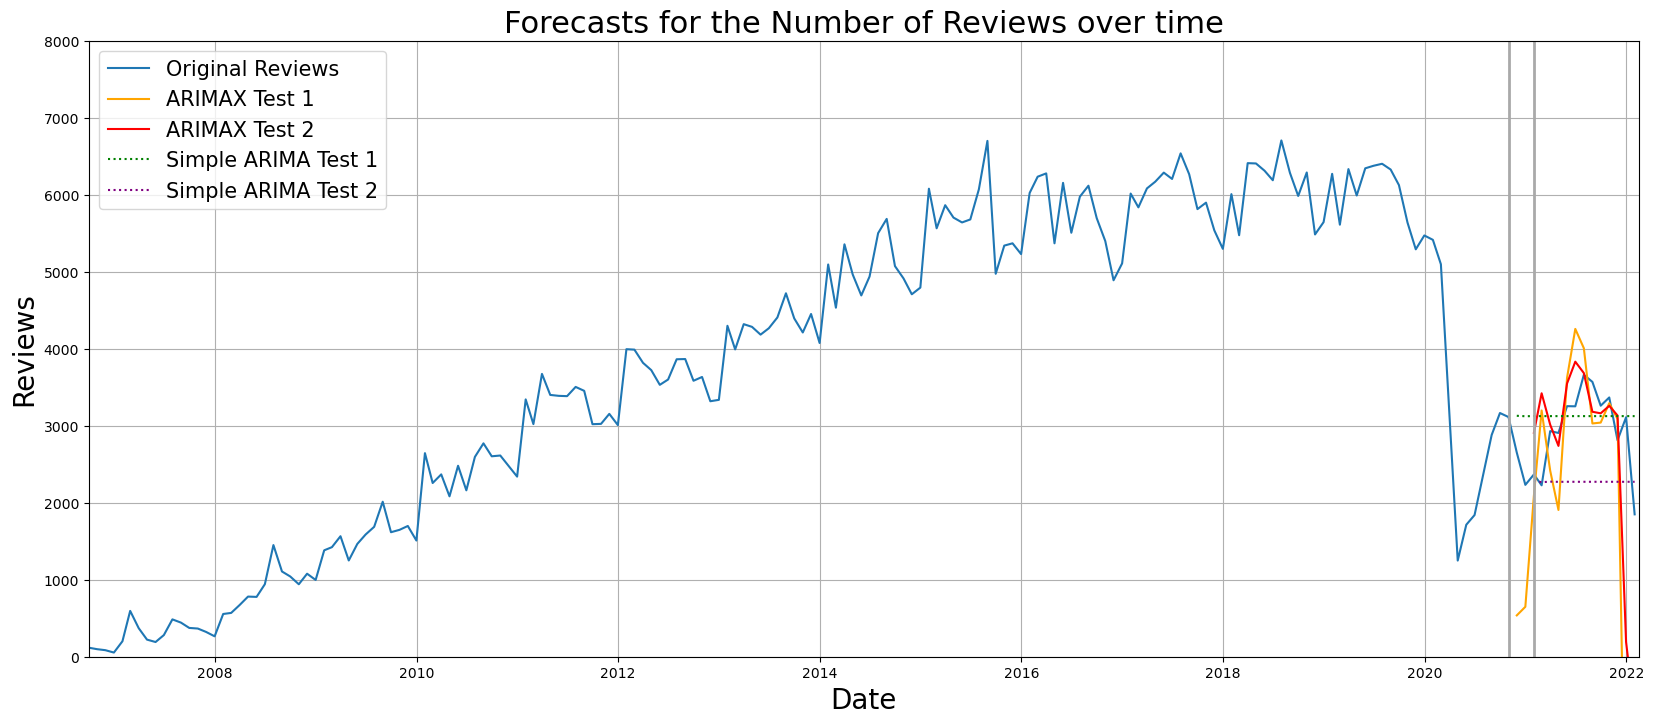

In [60]:
target = 'count'  

test_date_1 = '2020-10-31'
test_date_2 = '2021-01-30'  

monthly_reviews2 = monthly_reviews.merge(covid_cases_monthly[['date', 'covid_cases']], how='left', on='date')

monthly_reviews2['covid_cases'].fillna(0, inplace=True)

ts_train_1 = monthly_reviews2[monthly_reviews2['date'] <= test_date_1][['date', target]]
ts_test_1 = monthly_reviews2[monthly_reviews2['date'] > test_date_1][['date', target]]

ts_train_2 = monthly_reviews2[monthly_reviews2['date'] <= test_date_2][['date', target]]
ts_test_2 = monthly_reviews2[monthly_reviews2['date'] > test_date_2][['date', target]]

count_train_1 = ts_train_1[target].values
count_test_1 = ts_test_1[target].values
horizon_1 = len(ts_test_1)

count_train_2 = ts_train_2[target].values
count_test_2 = ts_test_2[target].values
horizon_2 = len(ts_test_2)

exog_var = ['covid_cases']

exog_train_1 = monthly_reviews2[monthly_reviews2['date'] <= test_date_1][exog_var]
exog_test_1 = monthly_reviews2[monthly_reviews2['date'] > test_date_1][exog_var]

exog_train_2 = monthly_reviews2[monthly_reviews2['date'] <= test_date_2][exog_var]
exog_test_2 = monthly_reviews2[monthly_reviews2['date'] > test_date_2][exog_var]

arimax_model_1 = sm.tsa.SARIMAX(count_train_1, exog=exog_train_1).fit()
y_hat_arimax_1 = arimax_model_1.get_forecast(steps=horizon_1, exog=exog_test_1)
ts_test_1['arimax_forecast'] = y_hat_arimax_1.predicted_mean

arimax_model_2 = sm.tsa.SARIMAX(count_train_2, exog=exog_train_2).fit()
y_hat_arimax_2 = arimax_model_2.get_forecast(steps=horizon_2, exog=exog_test_2)
ts_test_2['arimax_forecast'] = y_hat_arimax_2.predicted_mean

simple_arima_model_1 = sm.tsa.ARIMA(count_train_1, order=(1, 1, 1)).fit()    #CHECK THISSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
ts_test_1['arima_forecast'] = simple_arima_model_1.get_forecast(steps=horizon_1).predicted_mean

simple_arima_model_2 = sm.tsa.ARIMA(count_train_2, order=(1, 1, 1)).fit()
ts_test_2['arima_forecast'] = simple_arima_model_2.get_forecast(steps=horizon_2).predicted_mean

def visualize(train, test_arimax_1, test_arimax_2, test_arima_1, test_arima_2,  all_data, title):
    plt.figure(figsize=(20, 8))

    plt.plot(all_data['date'], all_data[target], label='Original Reviews')

    plt.plot(test_arimax_1['date'], test_arimax_1['arimax_forecast'], label='ARIMAX Test 1', color='orange', linestyle='-')

    plt.plot(test_arimax_2['date'], test_arimax_2['arimax_forecast'], label='ARIMAX Test 2', color='red', linestyle='-')

    plt.plot(test_arima_1['date'], test_arima_1['arima_forecast'], label='Simple ARIMA Test 1', color='green', linestyle=':')

    plt.plot(test_arima_2['date'], test_arima_2['arima_forecast'], label='Simple ARIMA Test 2', color='purple', linestyle=':')

    plt.title(title, fontsize=22)
    plt.ylabel('Reviews', fontsize=20)
    plt.xlabel('Date', fontsize=20)
    plt.legend(prop={'size': 15})
    plt.grid()
    plt.ylim(0, 8000)
    plt.xlim(pd.to_datetime('2006-10-01'), pd.to_datetime('2022-02-15')) 

    plt.axvline(x=pd.to_datetime(test_date_1), color='darkgray', lw=2, label='Start test 1')
    plt.axvline(x=pd.to_datetime(test_date_2), color='darkgray', lw=2, label='Start test 2')

    plt.show()

visualize(ts_train_1, ts_test_1, ts_test_2, ts_test_1, ts_test_2, monthly_reviews2, 'Forecasts for the Number of Reviews over time')



In [61]:
#MODEL 3 = ARIMA
from statsforecast.models import AutoARIMA

arima = AutoARIMA(trace=True)
arima = arima.fit(y=count_train)

y_hat_arima = arima.predict(h=horizon, level=[80, 95])
y_hat_arima


ARIMA(2,1,2)                   :2848.8132383575544

ARIMA(0,1,0)                   :2849.256424278757

ARIMA(1,1,0)                   :2844.5874347208037

ARIMA(0,1,1)                   :2844.915003204195

ARIMA(2,1,0)                   :2846.412753256889

ARIMA(1,1,1)                   :2846.3411877979797

ARIMA(2,1,1)                   :2848.4144289989626
Now re-fitting the best model(s) without approximations...


ARIMA(1,1,0)                   :2844.5874347208037


{'mean': array([2304.10735305, 2291.6981159 , 2293.83367019, 2293.46615427,
        2293.52940153, 2293.51851706, 2293.52039021, 2293.52006785,
        2293.52012333, 2293.52011378, 2293.52011543, 2293.52011514,
        2293.52011519]),
 'lo-95': 0     1463.408696
 1     1200.269046
 2      985.804591
 3      801.989362
 4      638.499673
 5      489.755305
 6      352.378618
 7      224.100912
 8      103.323595
 9      -11.132976
 10    -120.168125
 11    -224.486234
 12    -324.651199
 Name: 95%, dtype: float64,
 'lo-80': 0     1754.404048
 1     1578.051006
 2     1438.559427
 3     1318.241899
 4     1211.363629
 5     1114.101147
 6     1024.276008
 7      940.399613
 8      861.427589
 9      786.588457
 10     715.294205
 11     647.084260
 12     581.589910
 Name: 80%, dtype: float64,
 'hi-80': 0     2853.810658
 1     3005.345226
 2     3149.107914
 3     3268.690410
 4     3375.695174
 5     3472.935887
 6     3562.764773
 7     3646.640523
 8     3725.612658
 9     3800.451

In [62]:
ts_test['arima_forecast'] = y_hat_arima['mean']

In [63]:
#PLOT FORECASTS
def visualize(train, test, title):
    fig, ax = plt.subplots(1, 1, figsize = (20, 8))

    # Concatenate the dataframe of predicted values with the dataframe of observed values:
    plot_df = pd.concat([train, test]).set_index('date')
    plot_df.plot(ax=ax, linewidth=2)

    # Specify graph features:
    ax.set_title(title, fontsize=22)
    ax.set_ylabel('reviews', fontsize=20)
    ax.set_xlabel('date', fontsize=20)
    ax.legend(prop={'size': 15})
    ax.grid()

    # vertical line to indicate the split between train and test
    plt.axvline(x=test_date, color='red', linestyle='--', lw=1)

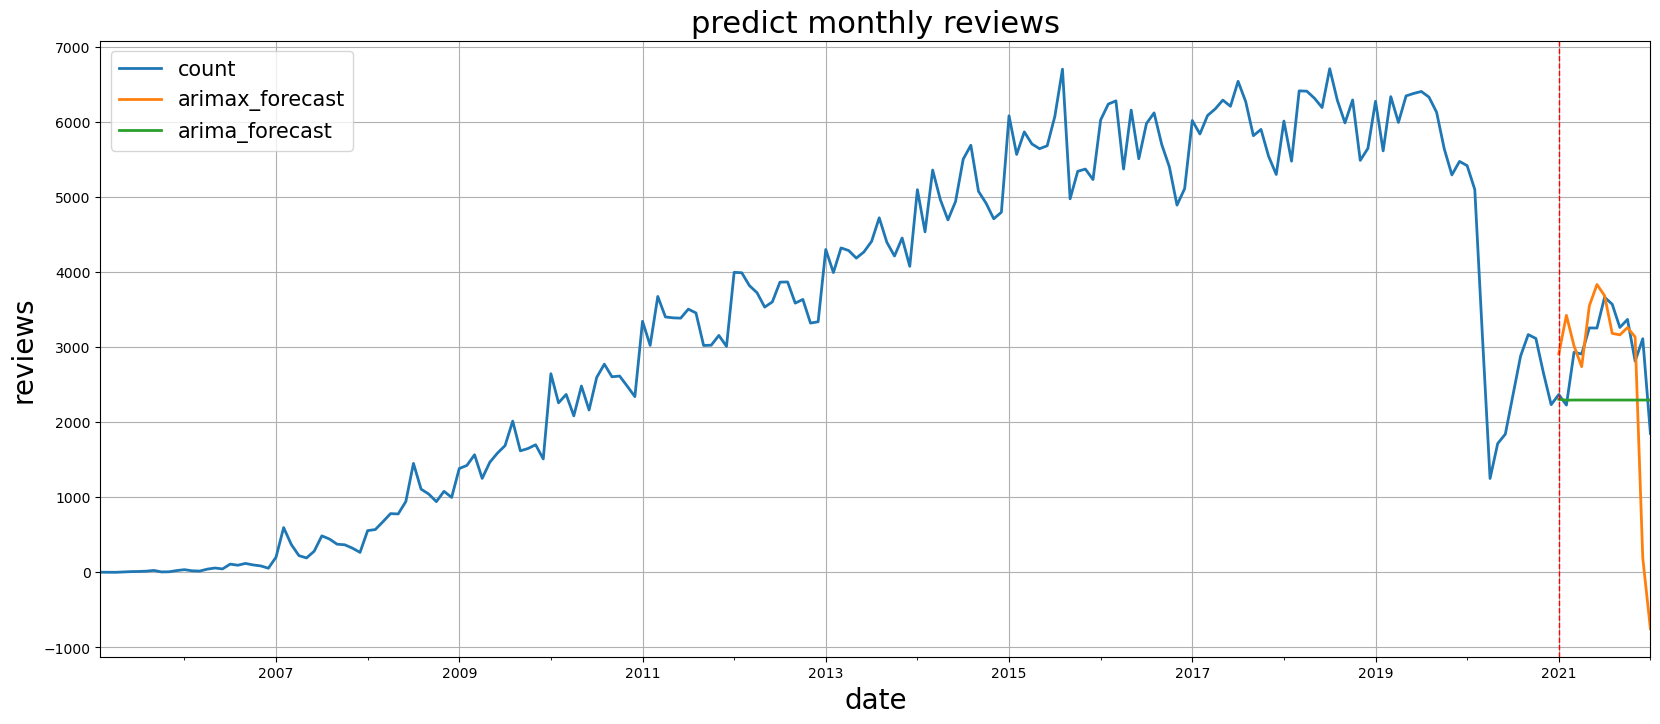

In [64]:
visualize(ts_train[['date', target]], ts_test, 'predict monthly reviews')

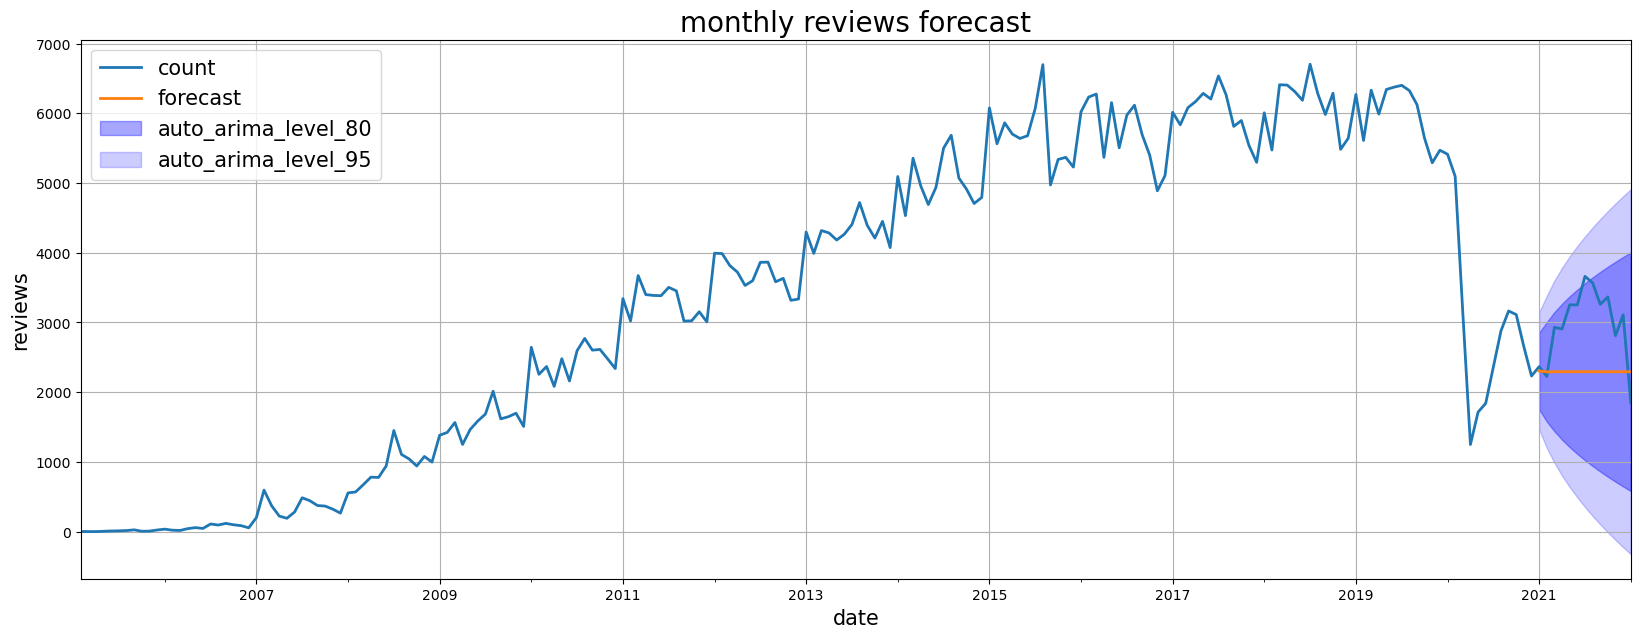

In [65]:
# Concatenate the dataframe of predicted values with the dataframe of observed values:
df_arima_test = pd.concat([ts_test.reset_index()[["date", "count"]], pd.DataFrame(y_hat_arima)], axis=1)
df_arima_test = df_arima_test.rename(columns={"mean": "forecast"})
df_plot = pd.concat([ts_train[['date', target]], df_arima_test]).set_index('date')

fig, ax = plt.subplots(1, 1, figsize = (20, 7))
df_plot[['count', 'forecast']].plot(ax=ax, linewidth=2)
# Specify graph features:
ax.fill_between(df_plot.index, 
                df_plot['lo-80'], 
                df_plot['hi-80'],
                alpha=.35,
                color='blue',
                label='auto_arima_level_80')
ax.fill_between(df_plot.index, 
                df_plot['lo-95'], 
                df_plot['hi-95'],
                alpha=.2,
                color='blue',
                label='auto_arima_level_95')
ax.set_title('monthly reviews forecast', fontsize=20)
ax.set_ylabel('reviews', fontsize=15)
ax.set_xlabel('date', fontsize=15)
ax.legend(prop={'size': 15})
ax.grid()

era top fazer o mesmo para o arimax com var exogenas